#LDA analysis

In [0]:
import pandas as pd
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [0]:
pip install pyLDAVis

     |████████████████████████████████| 1.6MB 10.0MB/s 
     |████████████████████████████████| 552kB 44.2MB/s 
  Created wheel for pyLDAVis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=2e77cb10be713021e962f14f01bacd8517c22358290d6d75ebff28cf4021d457
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=e6a017fddeb1ca0bc302ed801d58d350465f594144c9ba03e9c5339077ee19fe
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAVis funcy


In [0]:
from google.colab import files
uploaded = files.upload()

Saving Extracting_new_features.csv to Extracting_new_features.csv


In [0]:
df=pd.read_csv("Extracting_new_features.csv")

In [0]:
#1. Prepare Stopwords
#We have downloaded the stopwords. Let’s import them and make it available in stop_words.

# Run in python console
import nltk; nltk.download('stopwords')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# select the text columns only 
df=df[['Labele','TEXTE resulted']]


In [0]:
df=df.rename(columns={"TEXTE resulted":"TEXTE_resulted"})

In [0]:
# Convert to list
data = df.TEXTE_resulted.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove punctuation
data=[re.sub('[,\.!?]', '', sent) for sent in data]
# Convert the titles to lowercase
data=[sent.lower() for sent in data]

pprint(data[:1])

['ithe importance and popularity of travelling is still raising  everybody is '
 'interested in getting to know other countries and continents but the ways '
 'how to do it  are very differently  i agree with the statement that it is '
 'the best way to travel in a group led by a tour guide  if you travel in a '
 'group and you have a tour guide you get to know the most famous places and '
 'you get to know interesting things about the country you decided to visit  '
 'the tour guide would organise everything for you  so the only thing you '
 'would have to do is to go to the appointments with the group  another aspect '
 'is that you would get to know a lot of interesting people  when you travel '
 'in a group it is very easy to get to know other people because usually you '
 'sit in the same bus or you sleep in the same hotel like the others do  that '
 'is why you are never borring when you travel in groups  if you decide to '
 'travel in a group and you visit a country which is dan

After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s `simple_preprocess` is great for this.

# Tokenize words and Clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s `simple_preprocess()` is great for this. Additionally I have set deacc=True to remove the punctuations.

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['ithe', 'importance', 'and', 'popularity', 'of', 'travelling', 'is', 'still', 'raising', 'everybody', 'is', 'interested', 'in', 'getting', 'to', 'know', 'other', 'countries', 'and', 'continents', 'but', 'the', 'ways', 'how', 'to', 'do', 'it', 'are', 'very', 'differently', 'agree', 'with', 'the', 'statement', 'that', 'it', 'is', 'the', 'best', 'way', 'to', 'travel', 'in', 'group', 'led', 'by', 'tour', 'guide', 'if', 'you', 'travel', 'in', 'group', 'and', 'you', 'have', 'tour', 'guide', 'you', 'get', 'to', 'know', 'the', 'most', 'famous', 'places', 'and', 'you', 'get', 'to', 'know', 'interesting', 'things', 'about', 'the', 'country', 'you', 'decided', 'to', 'visit', 'the', 'tour', 'guide', 'would', 'organise', 'everything', 'for', 'you', 'so', 'the', 'only', 'thing', 'you', 'would', 'have', 'to', 'do', 'is', 'to', 'go', 'to', 'the', 'appointments', 'with', 'the', 'group', 'another', 'aspect', 'is', 'that', 'you', 'would', 'get', 'to', 'know', 'lot', 'of', 'interesting', 'people', 'when

#  Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are `min_count` and threshold. *The higher the values of these param, the harder it is for words to be combined to bigrams.*

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['ithe', 'importance', 'and', 'popularity', 'of', 'travelling', 'is', 'still', 'raising', 'everybody', 'is', 'interested', 'in', 'getting', 'to', 'know', 'other', 'countries', 'and', 'continents', 'but', 'the', 'ways', 'how', 'to', 'do', 'it', 'are', 'very', 'differently', 'agree', 'with', 'the', 'statement', 'that', 'it', 'is', 'the', 'best', 'way', 'to', 'travel', 'in', 'group_led', 'by', 'tour_guide', 'if', 'you', 'travel', 'in', 'group', 'and', 'you', 'have', 'tour_guide', 'you', 'get', 'to', 'know', 'the', 'most', 'famous', 'places', 'and', 'you', 'get', 'to', 'know', 'interesting', 'things', 'about', 'the', 'country', 'you', 'decided', 'to', 'visit', 'the', 'tour_guide', 'would', 'organise', 'everything', 'for', 'you', 'so', 'the', 'only', 'thing', 'you', 'would', 'have', 'to', 'do', 'is', 'to', 'go', 'to', 'the', 'appointments', 'with', 'the', 'group', 'another', 'aspect', 'is', 'that', 'you', 'would', 'get', 'to', 'know', 'lot', 'of', 'interesting', 'people', 'when', 'you', 'tr

# Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [0]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['importance', 'popularity', 'travel', 'still', 'raise', 'interested', 'get', 'know', 'country', 'continent', 'way', 'differently', 'agree', 'statement', 'good', 'way', 'travel', 'group_le', 'travel', 'group', 'know', 'famous', 'place', 'get', 'know', 'interesting', 'thing', 'country', 'decide', 'visit', 'would', 'organise', 'thing', 'would', 'go', 'appointment', 'group', 'aspect', 'would', 'know', 'lot', 'interesting', 'people', 'travel', 'group', 'easy', 'get', 'know', 'people', 'usually', 'sit', 'bus', 'sleep', 'hotel', 'other', 'never', 'borre', 'travel', 'group', 'decide', 'travel', 'group', 'visit', 'country', 'dangerouse', 'inform', 'dangerouse', 'say', 'avoid', 'risk', 'sometimes', 'special', 'rule', 'thing', 'bring', 'trouble', 'follow', 'furthermore', 'help', 'communication', 'problem', 'able', 'speak', 'language', 'people', 'country', 'visit', 'speak', 'help', 'able', 'speak', 'visit', 'doctor', 'go', 'police', 'happende', 'ask', 'would', 'able', 'help', 'reason', 'prefer',

# Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 4), (12, 2), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 2), (22, 1), (23, 6), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 5), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 3), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 3), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 6), (59, 1), (60, 1), (61, 4), (62, 2), (63, 4)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.



In [0]:
id2word[0]


'able'

In [0]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 3),
  ('agree', 1),
  ('appointment', 1),
  ('ask', 1),
  ('aspect', 1),
  ('avoid', 1),
  ('borre', 1),
  ('bring', 1),
  ('bus', 1),
  ('communication', 1),
  ('continent', 1),
  ('country', 4),
  ('dangerouse', 2),
  ('decide', 2),
  ('differently', 1),
  ('doctor', 1),
  ('easy', 1),
  ('famous', 1),
  ('follow', 1),
  ('furthermore', 1),
  ('get', 3),
  ('go', 2),
  ('good', 1),
  ('group', 6),
  ('group_le', 1),
  ('happende', 1),
  ('help', 3),
  ('hotel', 1),
  ('importance', 1),
  ('inform', 1),
  ('interested', 1),
  ('interesting', 2),
  ('know', 5),
  ('language', 1),
  ('lot', 1),
  ('never', 1),
  ('organise', 1),
  ('other', 1),
  ('people', 3),
  ('place', 1),
  ('police', 1),
  ('popularity', 1),
  ('prefer', 1),
  ('problem', 1),
  ('raise', 1),
  ('reason', 1),
  ('risk', 1),
  ('rule', 1),
  ('say', 1),
  ('sit', 1),
  ('sleep', 1),
  ('sometimes', 1),
  ('speak', 3),
  ('special', 1),
  ('statement', 1),
  ('still', 1),
  ('thing', 3),
  ('tour_guide', 1

# Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [0]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"stage" + 0.026*"professor" + 0.018*"crucial" + 0.016*"accomplish" + '
  '0.015*"objective" + 0.015*"exercise" + 0.013*"exemple" + 0.013*"smart" + '
  '0.013*"institution" + 0.010*"indicate"'),
 (1,
  '0.179*"car" + 0.024*"number" + 0.023*"people" + 0.022*"increase" + '
  '0.019*"today" + 0.016*"use" + 0.016*"few" + 0.014*"future" + '
  '0.011*"country" + 0.011*"drive"'),
 (2,
  '0.051*"world" + 0.037*"technology" + 0.031*"new" + 0.026*"develop" + '
  '0.022*"development" + 0.019*"change" + 0.018*"industry" + 0.017*"human" + '
  '0.016*"today" + 0.014*"country"'),
 (3,
  '0.110*"people" + 0.047*"think" + 0.036*"time" + 0.035*"thing" + '
  '0.031*"many" + 0.028*"lot" + 0.028*"want" + 0.026*"go" + 0.019*"reason" + '
  '0.016*"money"'),
 (4,
  '0.129*"product" + 0.082*"advertisement" + 0.042*"make" + 0.032*"buy" + '
  '0.027*"company" + 0.026*"really" + 0.024*"seem" + 0.022*"well" + '
  '0.019*"good" + 0.018*"much"'),
 (5,
  '0.097*"new" + 0.077*"thing" + 0.077*"risk" + 0.07

# Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [0]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.018886561080811

Coherence Score:  0.42568328706999925


# Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.



```
Each bubble on the left-hand side plot represents a topic.
The larger the bubble, the more prevalent is that topic.
```


```
A good topic model will have fairly big, non-overlapping bubbles 
scattered throughout the chart instead of being clustered in one quadrant.
---------------------------------------------------------------------------
A model with too many topics, will typically have many overlaps,
small sized bubbles clustered in one region of the chart.
```


```
if you move the cursor over one of the bubbles, the words and bars
on the right-hand side will update. These words are the salient keywords
that form the selected topic.
```






In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.254898 -0.070223       1        1  18.234371
3      0.273783  0.066873       2        1  14.145060
16     0.182842 -0.066582       3        1  10.763088
7      0.154964 -0.198192       4        1   7.824042
1      0.129649  0.100348       5        1   6.659619
18     0.149466  0.244944       6        1   5.938938
4      0.101958 -0.160044       7        1   5.890537
5      0.148037 -0.031216       8        1   5.604628
12     0.100650  0.309886       9        1   5.426122
8      0.119455 -0.198105      10        1   4.760314
13     0.127327 -0.000491      11        1   4.218986
2     -0.059540  0.044642      12        1   2.494648
17    -0.186656 -0.001941      13        1   1.818262
14    -0.189934 -0.018549      14        1   1.282679
11    -0.215240 -0.007887      15        1   0.936993
19    -0.204667  0.021135      16        1   0.923826
6     -0.217082 -0.004809      17        1   0.910010
9     -0.219866 -0.002185      18        1   0.754637
15    -0.224545 -0.015960      19        1   0.715919
0     -0.225500 -0.011643      20        1   0.697314, topic_info=            Term          Freq         Total Category  logprob  loglift
528          car  16255.000000  16255.000000  Default  30.0000  30.0000
38        people  39645.000000  39645.000000  Default  29.0000  29.0000
227        young  14672.000000  14672.000000  Default  28.0000  28.0000
767      product  10375.000000  10375.000000  Default  27.0000  27.0000
208          old   9101.000000   9101.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
4208  accomplish    148.731461    197.014084  Topic20  -4.1585   4.6846
1581    indicate     97.847298    140.149445  Topic20  -4.5772   4.6064
1603    security     76.299187    119.014694  Topic20  -4.8259   4.5211
1062      master     72.325569    302.825531  Topic20  -4.8794   3.5337
1438       enter     58.939873    260.946411  Topic20  -5.0841   3.4779

[1111 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.276844       able
0         3  0.458039       able
0         4  0.168126       able
0         5  0.007723       able
0         9  0.037427       able
...     ...       ...        ...
2593      6  0.628331  youngster
2593      9  0.370384  youngster
458       6  0.653753      youth
458       9  0.345591      youth
4319      9  0.980564       zeal

[1920 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 17, 8, 2, 19, 5, 6, 13, 9, 14, 3, 18, 15, 12, 20, 7, 10, 16, 1])

#Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.


In [48]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [49]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [50]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-05-15 16:38:21--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.23MB/s    in 1.7s    

2020-05-15 16:38:23 (9.23 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [51]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
corpus_path = 'transcripts' # you need to change this path to the directory containing your corpus of .txt files

In [0]:
def load_data_from_dir(path):
    file_list = glob.glob(path + '/*.txt')

    # create document list:
    documents_list = []
    source_list = []
    for filename in file_list:
        with open(filename, 'r', encoding='utf8') as f:
            text = f.read()
            f.close()
            documents_list.append(text)
            source_list.append(os.path.basename(filename))
    print("Total Number of Documents:",len(documents_list))
    return documents_list, source_list

def preprocess_data(doc_set,extra_stopwords = {}):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # replace all newlines or multiple sequences of spaces with a standard space
    doc_set = [re.sub('\s+', ' ', doc) for doc in doc_set]
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # add any extra stopwords
    if (len(extra_stopwords) > 0):
        en_stop = en_stop.union(extra_stopwords)
    
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

def prepare_corpus(doc_clean):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [55]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [56]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('order', 0.05159045261338689),
   ('make', 0.03365407071792237),
   ('result', 0.027044700826755103),
   ('create', 0.023564855901723573),
   ('part', 0.020271848288103134),
   ('great', 0.015297304871782895),
   ('real', 0.01233126255313186),
   ('true', 0.01221448923349993),
   ('instance', 0.011700686627119436),
   ('mind', 0.010743145406137605)]),
 (4,
  [('people', 0.8157423585495804),
   ('live', 0.03360728229685714),
   ('tend', 0.007571345369831101),
   ('meet', 0.0057378286848292675),
   ('strong', 0.005198559071593434),
   ('disagree', 0.0039043119998274337),
   ('generally', 0.0036454625854742337),
   ('thi', 0.0036023210164153672),
   ('care', 0.003408183955650467),
   ('peole', 0.0032571884639444335)]),
 (6,
  [('problem', 0.11343008299762171),
   ('important', 0.0735572489443285),
   ('situation', 0.05307479493277678),
   ('find', 0.04991991457554725),
   ('question', 0.036766490316944136),
   ('lot', 0.03150026695141484),
   ('face', 0.026525263311168275),
   ('

#How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.



In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [59]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


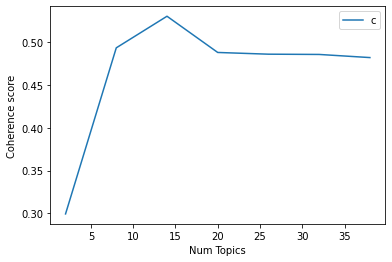

In [60]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2993
Num Topics = 8  has Coherence Value of 0.4934
Num Topics = 14  has Coherence Value of 0.5303
Num Topics = 20  has Coherence Value of 0.488
Num Topics = 26  has Coherence Value of 0.486
Num Topics = 32  has Coherence Value of 0.4856
Num Topics = 38  has Coherence Value of 0.482


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [62]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.146*"thing" + 0.117*"risk" + 0.091*"successful" + 0.046*"success" + '
  '0.023*"person" + 0.020*"business" + 0.015*"people" + 0.013*"succeed" + '
  '0.012*"man" + 0.010*"fail"'),
 (1,
  '0.076*"time" + 0.059*"day" + 0.042*"live" + 0.042*"year" + 0.036*"family" + '
  '0.032*"friend" + 0.026*"feel" + 0.020*"child" + 0.019*"home" + 0.019*"man"'),
 (2,
  '0.029*"great" + 0.022*"part" + 0.016*"play" + 0.015*"start" + 0.015*"put" + '
  '0.014*"show" + 0.013*"end" + 0.011*"give" + 0.011*"statement" + '
  '0.010*"realize"'),
 (3,
  '0.115*"community" + 0.109*"young" + 0.087*"time" + 0.056*"people" + '
  '0.037*"give" + 0.029*"nowadays" + 0.025*"society" + 0.019*"spend" + '
  '0.015*"generation" + 0.014*"activity"'),
 (4,
  '0.022*"case" + 0.021*"individual" + 0.018*"order" + 0.017*"issue" + '
  '0.010*"sense" + 0.010*"simply" + 0.010*"true" + 0.010*"process" + '
  '0.010*"instance" + 0.009*"base"'),
 (5,
  '0.125*"person" + 0.096*"life" + 0.069*"experience" + 0.040*"situation" + '
  

# Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [63]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Document_No  ...                                               Text
0            0  ...  ithe importance and popularity of travelling i...
1            1  ...  it is an important decision  how to plan your ...
2            2  ...  some people believe that young people can enjo...
3            3  ...  travelling is usually considered as good recre...
4            4  ...  i agree that  life is a person live period of ...
5            5  ...  in my opinion  travel in group with a tour gui...
6            6  ...  i thing the statement  young people nowadays d...
7            7  ...  whether or not young people enjoy life more th...
8            8  ...  in the era of science and technology  the peop...
9            9  ...  i agree with this statement  i think that in t...

[10 rows x 5 columns]

#Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [64]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  ...                                               Text
0        0.0  ...  how successful are youhave you ever felt that ...
1        1.0  ...  nowadays  most of the young people have a job ...
2        2.0  ...  facts are the core of life  with out facts you...
3        3.0  ...  i disagree with the idea that these days child...
4        4.0  ...  as far as i am concerned  i take side for the ...

[5 rows x 4 columns]

The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.
#Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.


In [65]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


Dominant_Topic  ... Perc_Documents
0.0               19.0  ...         0.1155
1.0               13.0  ...         0.0083
2.0                7.0  ...         0.0034
3.0               19.0  ...         0.1084
4.0                7.0  ...         0.0037
...                ...  ...            ...
9895.0             1.0  ...            NaN
9896.0             0.0  ...            NaN
9897.0            17.0  ...            NaN
9898.0            17.0  ...            NaN
9899.0            11.0  ...            NaN

[9900 rows x 4 columns]

#Conclusion
We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.
